In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import os, sys
import tqdm
import matplotlib.patches as mpatches
from PIL import Image as im
import seaborn as sns
import geopandas as gpd
import contextily as cx
from shapely.geometry import LineString
import datetime
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
import re
import skgstat as skg
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from pykrige.ok import OrdinaryKriging
import matplotlib.patches as patches 
from shapely.geometry import Polygon
from sklearn.metrics import mean_absolute_error

In [3]:
fd = "/Users/nandanmaiti/LICIT_LAB Dropbox/Nandan Maiti/WP3.3/Athens_loops/"

In [4]:
df1 = pd.read_json (r'/Users/nandanmaiti/LICIT_LAB Dropbox/Nandan Maiti/WP3.3/Athens_loops/acumen_aadt_1.json')
df2 = pd.read_json (r'/Users/nandanmaiti/LICIT_LAB Dropbox/Nandan Maiti/WP3.3/Athens_loops/acumen_aadt_2.json')
df3 = pd.read_json (r'/Users/nandanmaiti/LICIT_LAB Dropbox/Nandan Maiti/WP3.3/Athens_loops/acumen_aadt_3.json')
df4 = pd.read_json (r'/Users/nandanmaiti/LICIT_LAB Dropbox/Nandan Maiti/WP3.3/Athens_loops/acumen_aadt_4.json')
df=pd.concat([df1,df2,df3,df4], axis=0)

In [1335]:
detectors = gpd.read_file(fd+"detectors.shp")
detectors = detectors.set_crs('EPSG:32234', allow_override=True)
detectors = detectors.to_crs(epsg=4326)

sections = gpd.read_file(fd+"sections.shp")
sections = sections.set_crs('EPSG:32234', allow_override=True)
sections = sections.to_crs(epsg=4326)

In [1336]:
# Convert the datetime column to datetime type
df['appprocesstime'] = pd.to_datetime(df['appprocesstime'])

# Extract date and time into separate columns
df['date'] = df['appprocesstime'].dt.date
df['time'] = df['appprocesstime'].dt.time


In [1337]:
sections["section_id"]=sections["id"]
sections["section_geo"]=sections["geometry"]
new_sections = sections[['section_geo','section_id','func_class']]
detectors_sections = pd.merge(detectors, new_sections, on='section_id')

In [1338]:
detectors_sections = detectors_sections.groupby('func_class', group_keys=False).apply(lambda x: x.sample(frac=0.2, random_state=42))

In [1339]:
detectors_sections["deviceid"]=detectors_sections["name"]

In [1340]:
len(detectors_sections["deviceid"].unique())

52

In [1341]:
new_detectors_sections=detectors_sections[['geometry','deviceid', 'from_lane', 'to_lane']]

new_detectors_sections['total_lane']=new_detectors_sections['to_lane']-new_detectors_sections['from_lane']

/opt/homebrew/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [1342]:

df_new=pd.merge(df, new_detectors_sections, on='deviceid')
df_new.sort_values(by=['date'])

,appprocesstime,average_speed,countedcars,deviceid,road_info,road_name,date,time,geometry,from_lane,to_lane,total_lane
12296,2022-08-02 08:00:00+00:00,41.097561,2769,MS254,ΚΑΤΕΥΘΥΝΣΗ ΠΡΟΣ ΒΑΣ. ΚΩΝ/ΝΟΥ ΠΡΙΝ ΑΠΟ ΤΗΝ ΜΕΣΟ...,ΒΑΣ. ΣΟΦΙΑΣ,2022-08-02,08:00:00,POINT (23.76090 37.98484),0.0,4.0,4.0
12286,2022-08-02 18:00:00+00:00,42.390244,2580,MS254,ΚΑΤΕΥΘΥΝΣΗ ΠΡΟΣ ΒΑΣ. ΚΩΝ/ΝΟΥ ΠΡΙΝ ΑΠΟ ΤΗΝ ΜΕΣΟ...,ΒΑΣ. ΣΟΦΙΑΣ,2022-08-02,18:00:00,POINT (23.76090 37.98484),0.0,4.0,4.0
12285,2022-08-02 19:00:00+00:00,44.853659,2318,MS254,ΚΑΤΕΥΘΥΝΣΗ ΠΡΟΣ ΒΑΣ. ΚΩΝ/ΝΟΥ ΠΡΙΝ ΑΠΟ ΤΗΝ ΜΕΣΟ...,ΒΑΣ. ΣΟΦΙΑΣ,2022-08-02,19:00:00,POINT (23.76090 37.98484),0.0,4.0,4.0
12284,2022-08-02 20:00:00+00:00,46.000000,2520,MS254,ΚΑΤΕΥΘΥΝΣΗ ΠΡΟΣ ΒΑΣ. ΚΩΝ/ΝΟΥ ΠΡΙΝ ΑΠΟ ΤΗΝ ΜΕΣΟ...,ΒΑΣ. ΣΟΦΙΑΣ,2022-08-02,20:00:00,POINT (23.76090 37.98484),0.0,4.0,4.0
12283,2022-08-02 23:00:00+00:00,49.634146,1170,MS254,ΚΑΤΕΥΘΥΝΣΗ ΠΡΟΣ ΒΑΣ. ΚΩΝ/ΝΟΥ ΠΡΙΝ ΑΠΟ ΤΗΝ ΜΕΣΟ...,ΒΑΣ. ΣΟΦΙΑΣ,2022-08-02,23:00:00,POINT (23.76090 37.98484),0.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
61269,2023-05-05 00:00:00+00:00,40.365854,657,MS421,ΚΥΡΙΟΣ ΔΡΟΜΟΣ ΜΕ ΚΑΤΕΥΘΥΝΣΗ ΠΡΟΣ Λ. ΚΗΦΙΣΙΑΣ 1...,Λ. ΑΛΕΞΑΝΔΡΑΣ,2023-05-05,00:00:00,POINT (23.75658 37.98668),0.0,1.0,1.0
73483,2023-05-05 00:00:00+00:00,31.000000,359,MS431,ΔΕΞΙΟΣ ΚΛΑΔΟΣ ΜΕ ΚΑΤΕΥΘΥΝΣΗ Λ. ΑΛΕΞΑΝΔΡΑΣ 120 ...,ΦΕΙΔΙΠΠΙΔΟΥ,2023-05-05,00:00:00,POINT (23.76288 37.98551),0.0,2.0,2.0
116314,2023-05-05 00:00:00+00:00,44.097561,478,MS704,ΚΥΡΙΟΣ ΔΡΟΜΟΣ ΜΕ ΚΑΤΕΥΘΥΝΣΗ ΟΜΟΝΟΙΑ 150 Μ. ΠΡΙ...,ΠΕΙΡΑΙΩΣ,2023-05-05,00:00:00,POINT (23.71533 37.97853),1.0,2.0,1.0
91830,2023-05-05 00:00:00+00:00,53.439024,839,MS486,ΚΥΡΙΟΣ ΔΡΟΜΟΣ ΜΕ ΚΑΤΕΥΘΥΝΣΗ ΠΡΟΣ ΑΓ. ΠΑΡΑΣΚΕΥΗ...,Λ. ΜΕΣΟΓΕΙΩΝ,2023-05-05,00:00:00,POINT (23.77277 37.99033),0.0,2.0,2.0


In [1343]:
def g(df):
    df['countedcars'] = np.where(df['total_lane']==0, df['countedcars'], df['countedcars'] / df['total_lane'])
    return df

df_new = g(df_new.copy())

df_new[['countedcars']] = df_new[['countedcars']].fillna(0)

In [1344]:
df_new.reset_index(drop=True,  inplace=True)
df_new['appprocesstime'] = pd.to_datetime(df_new['appprocesstime'])

df_new['DATE-TIME'] = df_new['appprocesstime'].dt.tz_localize(None)

df_new['date'] = df_new['appprocesstime'].dt.date
df_new['time'] = df_new['appprocesstime'].dt.time
df_new.set_index('DATE-TIME', inplace=True)
df_new.drop('appprocesstime', axis=1, inplace=True)

In [1345]:
origin = '2022-11-01 17:00:00'
end_time = '2022-11-01 18:00:00'


# origin = '2022-11-07 00:00:00'
# end_time = '2022-11-11 23:00:00'

df_resampled = df_new[(df_new.index >= origin) & (df_new.index <= end_time)]

df_resampled = df_resampled.reset_index()

# resampled_count['date'] = resampled_count['DATE-TIME'].dt.date
# resampled_count['time'] = resampled_count['DATE-TIME'].dt.time


In [1346]:
points_wkt=df_resampled['geometry']
z = df_resampled['countedcars'].values

In [1347]:
coordinates = np.array([(point.x, point.y) for point in points_wkt])

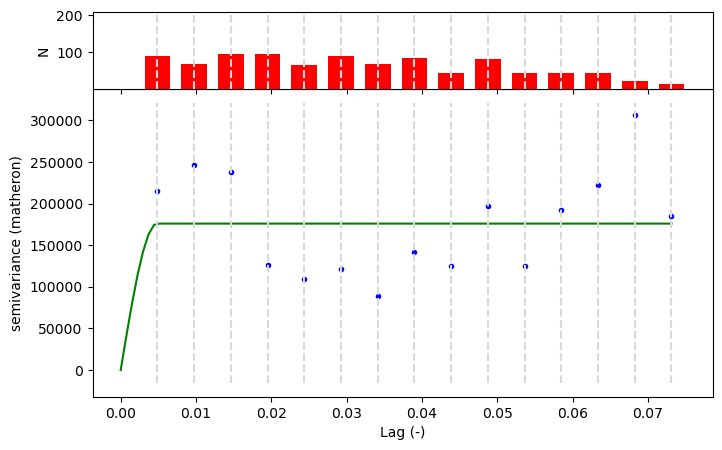

In [1348]:
# n_lags=10, maxlag=0.5, normalize=False, use_nugget=True
V = skg.Variogram(coordinates, z,n_lags = 15,normalize=False)
V.model = 'spherical'
V.plot(show=False);

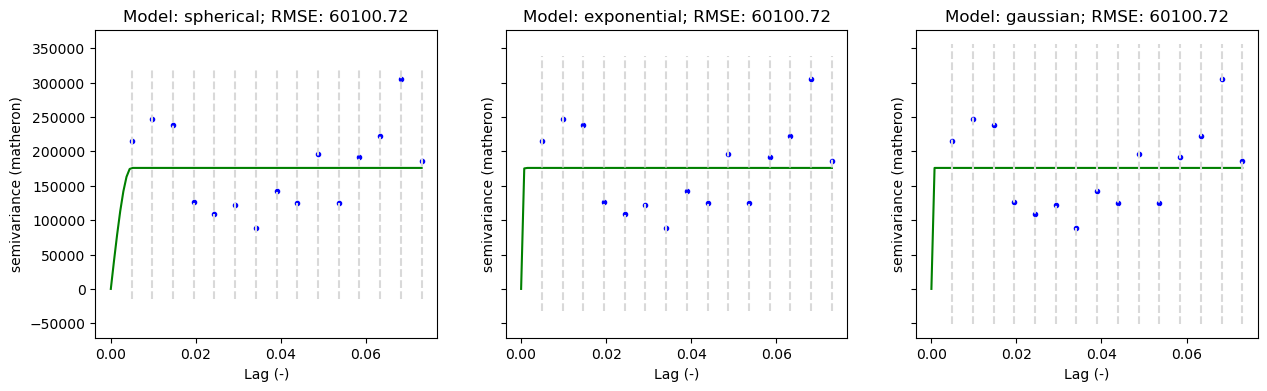

In [1349]:
fig, _a = plt.subplots(1,3, figsize=(15, 4), sharex=True, sharey=True)
axes = _a.flatten()
# 'matern', 'stable', 'cubic'
for i, model in enumerate(('spherical', 'exponential', 'gaussian')):
    V.model = model
    V.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model: %s; RMSE: %.2f' % (model, V.rmse))

In [1350]:
def interpolate(V, ax):
    lon_min, lon_max = coordinates[:, 0].min(), coordinates[:, 0].max()
    lat_min, lat_max = coordinates[:, 1].min(), coordinates[:, 1].max()

    # Create a grid over the geographic area
    xx, yy = np.mgrid[lon_min:lon_max:100j, lat_min:lat_max:100j]

    # Apply Ordinary Kriging with adjusted parameters
    ok = skg.OrdinaryKriging(V, min_points=1, max_points=5, mode='exact')
    field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    
    field = field.T
#     cx.add_basemap(ax=ax, crs='EPSG:32234', source=cx.providers.OpenStreetMap.Mapnik)

    # Plot the interpolated field
    sec = sections.plot(ax=ax, color='grey',linewidth=1.0, alpha=0.7)
    art = ax.matshow(field, origin='lower', extent=[lon_min, lon_max, lat_min, lat_max], cmap='jet', vmin=0, vmax=2000)
    scatter = ax.scatter(coordinates[:, 0], coordinates[:, 1], c=z,  cmap='jet', vmin=0, vmax=2000,s=20, edgecolors='black')
    ax.set_title(f'{V.model.__name__} model')
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    plt.colorbar(art, ax=ax)
    
    
    return field

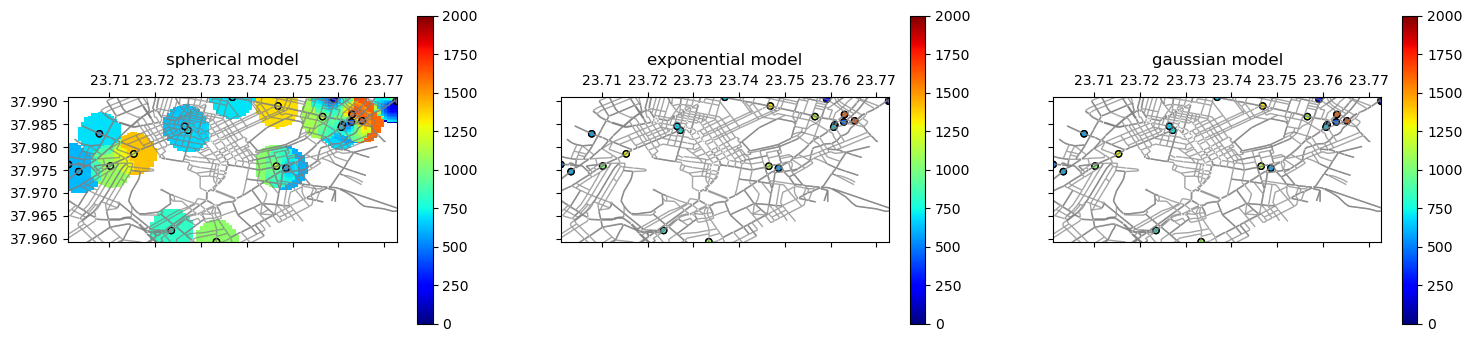

In [1351]:
fields = []
fig, _a = plt.subplots(1,3, figsize=(18, 4), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential','gaussian')):
    V.model = model
    fields.append(interpolate(V, axes[i]))
    
# plt.tight_layout()
# plt.show()

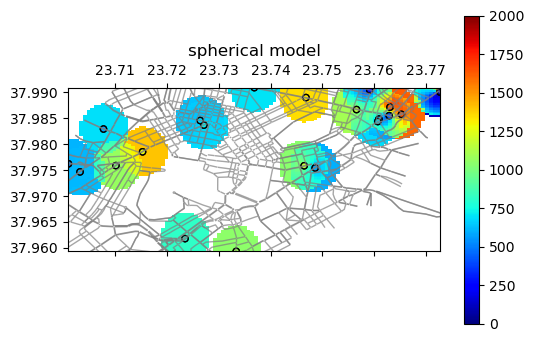

In [1352]:
fields = []
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharex=True, sharey=True)

# Set model to 'spherical'
V.model = 'spherical'
fields.append(interpolate(V, ax))

pd.DataFrame({'spherical': fields[0].flatten(), 'exponential': fields[1].flatten(), 'gaussian': fields[2].flatten()}).describe()

In [170]:


# Step 1: Split your data into training and validation sets
coordinates_train, coordinates_val, z_train, z_val = train_test_split(coordinates, z, test_size=0.1, random_state=42)

# Step 2: Fit the Kriging model on the training data
V_train = skg.Variogram(coordinates_train, z_train, n_lags=5,normalize=False)
V_train.model = 'spherical'
V_train.fit()

# Step 3: Predict on the validation set
ok = skg.OrdinaryKriging(V_train, min_points=1, max_points=5, mode='exact')
z_pred = ok.transform(coordinates_val)

krig_variances = []
for coord in coordinates_val:
    dists = np.linalg.norm(coordinates_train - coord, axis=1)
    gamma = V_train.transform(dists)
    krig_variances.append(np.mean(gamma))

krig_variances = np.array(krig_variances)

# Step 5: Filter out NaN predictions
valid_mask = ~np.isnan(z_pred)
z_pred_valid = z_pred[valid_mask]
z_val_valid = z_val[valid_mask]
krig_variances_valid = krig_variances[valid_mask]

# Step 6: Compute the squared errors
squared_errors = (z_val_valid - z_pred_valid) ** 2

# Step 7: Compute the MSDR
if len(squared_errors) > 0 and len(krig_variances_valid) > 0:
    MSDR = np.mean(squared_errors) / np.mean(krig_variances_valid)
else:
    MSDR = np.nan

print(f"Mean Squared Deviation Ratio (MSDR): {MSDR}")


Mean Squared Deviation Ratio (MSDR): 0.27341916295044805


In [171]:
# Step 2: Fit the Kriging model on the training data
ok = OrdinaryKriging(coordinates_train[:, 0], coordinates_train[:, 1], z_train, variogram_model='spherical')

# Step 3: Predict on the validation set, including variances
z_pred, krig_variances = ok.execute('points', coordinates_val[:, 0], coordinates_val[:, 1])

# Step 4: Compute the squared errors
squared_errors = (z_val - z_pred) ** 2

# Step 5: Compute the MSDR
MSDR = np.mean(squared_errors) / np.mean(krig_variances)

print(f"Mean Squared Deviation Ratio (MSDR): {MSDR}")

Mean Squared Deviation Ratio (MSDR): 1.2042904743121925


In [172]:
Interpreting MSDR
MSDR ≈ 1:
This suggests that the Kriging variances are appropriate for the observed prediction errors, indicating a well-calibrated model.
MSDR > 1:
This indicates that the model underestimates the variability (the Kriging variances are too small relative to the actual prediction errors).
MSDR < 1:
This suggests that the model overestimates the variability (the Kriging variances are too large).

SyntaxError: invalid character '≈' (U+2248) (3113056361.py, line 2)

In [624]:
import numpy as np
from shapely.geometry import LineString, Polygon
import geopandas as gpd

def calculate_total_section_lengths(sections, lon_min, lon_max, lat_min, lat_max, grid_size=25):
    # Create the grid
    grid_width = (lon_max - lon_min) / grid_size
    grid_height = (lat_max - lat_min) / grid_size
    
    # Initialize the array to store total lengths
    total_lengths = np.zeros((grid_size, grid_size))
    
    for section in sections.geometry:
        for i in range(grid_size):
            for j in range(grid_size):
                # Define the grid cell as a polygon
                grid_cell = Polygon([
                    (lon_min + i * grid_width, lat_min + j * grid_height),
                    (lon_min + (i + 1) * grid_width, lat_min + j * grid_height),
                    (lon_min + (i + 1) * grid_width, lat_min + (j + 1) * grid_height),
                    (lon_min + i * grid_width, lat_min + (j + 1) * grid_height)
                ])
                
                # Calculate the intersection of the section with the grid cell
                intersection = section.intersection(grid_cell)
                
                # Add the length of the intersection to the total length
                total_lengths[i, j] += intersection.length
    
    return total_lengths

# Load the sections shapefile (replace 'your_shapefile.shp' with the actual path to your shapefile)
section = gpd.read_file(fd+"sections.shp")
section = section.set_crs('EPSG:32234', allow_override=True)

# Define the bounding box (replace these with your actual coordinates)
lon_min, lat_min, lon_max, lat_max = section.total_bounds

# Calculate the total section lengths on each grid cell
total_lengths = calculate_total_section_lengths(section, lon_min, lon_max, lat_min, lat_max)

# # Output the total lengths
# print("Total section lengths on each grid cell:")
# print(total_lengths)


Total section lengths on each grid cell:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10659543e+02
  3.20055822e+02 9.51262939e+02 6.09510357e+02 1.16653086e+02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.81782184e+02 1.38125292e+02 7.68042616e+02
  9.06978530e+02 1.09285111e+03 1.72015014e+03 4.86446395e+02
  4.73818569e+02 4.45847842e+02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.48554435e+01
  3.80154539e+02 2.63154901e+02 7.14530893e+02 7.10729106e+02
  1.20003801e+03 7.85045766e+02 7.02767872e+02 4.618471

In [686]:
#save total_length_matrix
# np.savetxt("total_lengths.txt", total_lengths)
b = np.loadtxt('total_lengths.txt', dtype=int)

/var/folders/96/r5br96px2f55f38jlx1nwy0m0000gn/T/ipykernel_27525/3505694085.py:3: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  b = np.loadtxt('total_lengths.txt', dtype=int)


array([[   0,    0,    0,    0,    0,    0,    0,  310,  320,  951,  609,
         116,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0,  381,  138,  768,  906, 1092, 1720,
         486,  473,  445,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,   84,  380,  263,  714,  710, 1200,  785,  702,
         461, 1474, 1009,  626,   61,  202,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,  241,  204,  874,  472,  651,  728,  990, 1913,  808, 1080,
        1043, 1548, 1470, 1188,  485,  142,  105,    0,    0,    0,    0,
           0,    0,    0],
       [   0,  417, 2093,  579, 1292,  863,  715, 1189,  679, 1496, 1069,
         879, 1745,  691, 1058, 1096,  678, 1277,  896,  565,  154,    0,
           0,    0,    0],
       [   0,  290,  382, 2728, 1284, 1137,  664, 1694,  506,  646,  455,
        1044, 1472, 1189, 1031,  802, 1250,  902, 1

In [680]:
q_net = np.nansum((total_lengths/1000)*fields[0])/np.nansum((total_lengths/1000))

640.6371710804667

In [ ]:
#q_equipped
#DATE-TIME	q
#0	2022-11-01 12:00:00	 1155.208967
#1	2022-11-01 13:00:00	 1115.033111

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


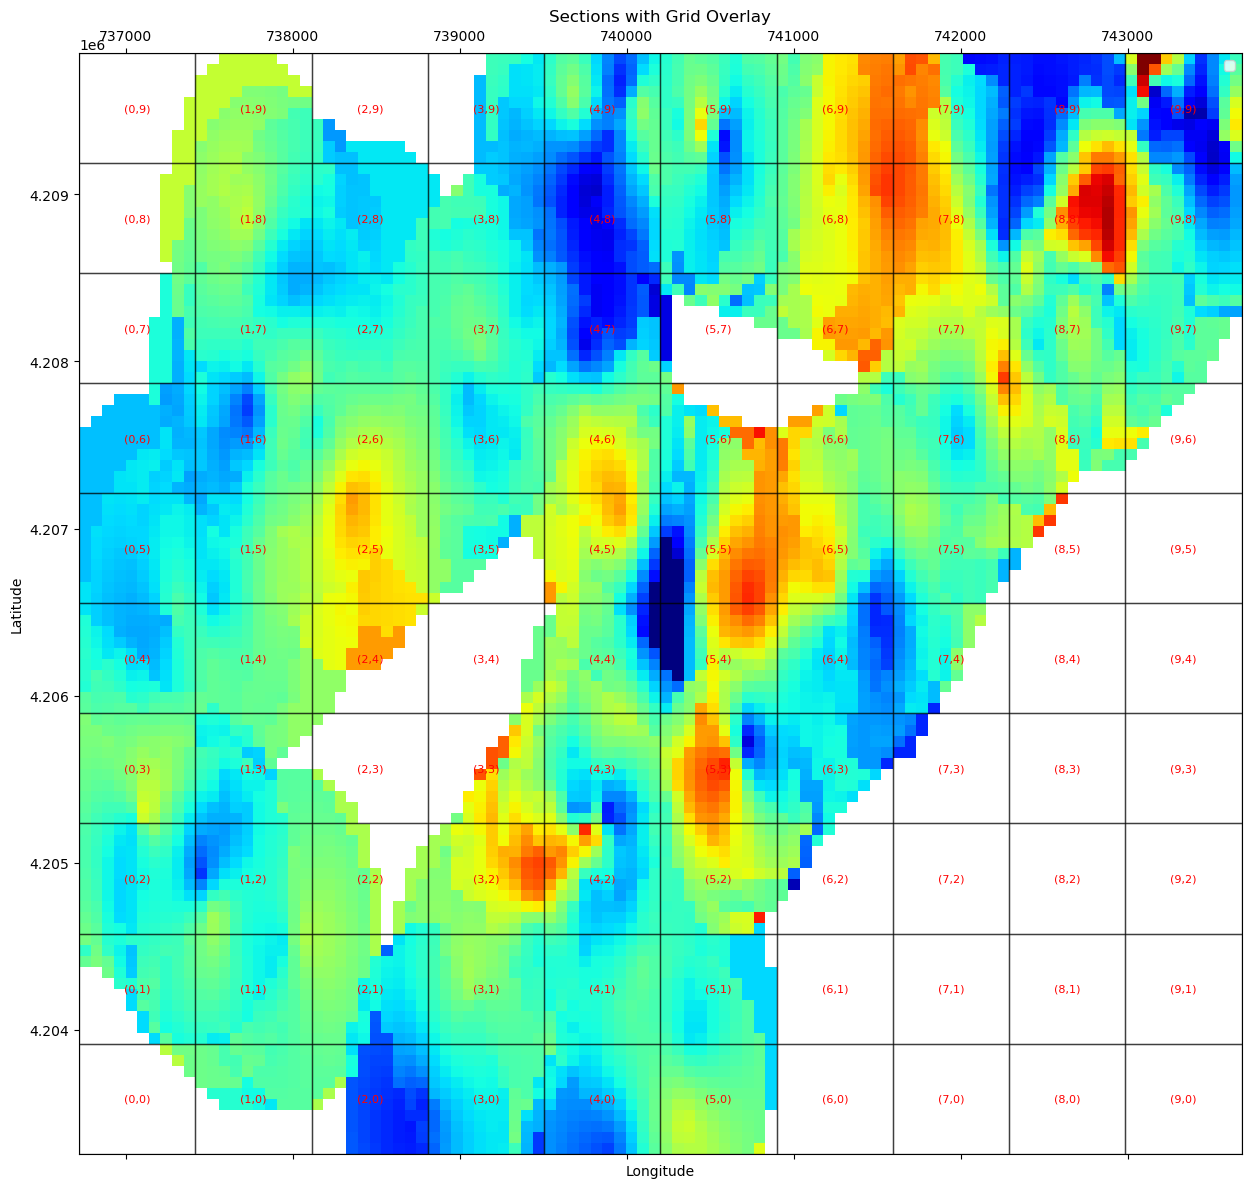

In [804]:
def plot_sections_with_grid(sections, lon_min, lon_max, lat_min, lat_max, grid_size=10):
    total_lengths = calculate_total_section_lengths(sections, lon_min, lon_max, lat_min, lat_max, grid_size)
    
    # Plot the sections
    fig, ax = plt.subplots(figsize=(15, 15))
#     sections.plot(ax=ax, color='blue', linewidth=2, label='Sections')
    art = ax.matshow(fields[0], origin='lower', extent=[lon_min, lon_max, lat_min, lat_max], cmap='jet', vmin=0, vmax=2000)
    
    # Calculate grid dimensions
    grid_width = (lon_max - lon_min) / grid_size
    grid_height = (lat_max - lat_min) / grid_size

    # Plot the grid
    for i in range(grid_size):
        for j in range(grid_size):
            rect = patches.Rectangle((lon_min + i * grid_width, lat_min + j * grid_height), grid_width, grid_height,
                                     linewidth=1, edgecolor='black', facecolor='none',alpha=0.5)
            ax.add_patch(rect)
            # Calculate the center of the grid cell for text placement
            center_x = lon_min + i * grid_width + grid_width / 2
            center_y = lat_min + j * grid_height + grid_height / 2
            
            # Add the (i, j) text inside the grid cell
            ax.text(center_x, center_y, f'({i},{j})', color='red', fontsize=8, ha='center', va='center')
    
    
    # Set the extent of the plot
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    
    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Sections with Grid Overlay')
    
    plt.legend()
    plt.show()

# Example usage
plot_sections_with_grid(section, lon_min, lon_max, lat_min, lat_max)
